In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Anime Recommendation System
## Dataset Used
We used this [ratings dataset](https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database) provided by COOPERUNION.  
This data set contains information on user preference data from 73,516 users on 12,294 anime. Each user is able to add anime to their completed list and give it a rating and this data set is a compilation of those ratings.  
### Content
Anime.csv

anime_id - myanimelist.net's unique id identifying an anime.  
name - full name of anime.  
genre - comma separated list of genres for this anime.  
type - movie, TV, OVA, etc.  
episodes - how many episodes are in this show. (if movie).  
rating - average rating out of 10 for this anime.
members - number of community members that are in this anime's group.  


Rating.csv

user_id - non identifiable randomly generated user id.  
anime_id - the anime that this user has rated.  
rating - rating out of 10 this user has assigned (-1 if the user watched it bididn't ass  i  gn a rating).

## Data preparation
Let's load this data into Python. I will load the dataset with Pandas onto Dataframes ratings and anime. Additionally, to make it easy to use series from the ratings dataframe as training inputs and output to the Keras model, I set max_userid as the max value of user_id in the ratings and max_animeid as the max value of anime_id in the ratings.

In [4]:
import pandas as pd
import numpy as np

anime = pd.read_csv(r"D:\projrct\Anuime recommendation system\anime.csv")
ratings = pd.read_csv(r"D:\projrct\Anuime recommendation system\rating.csv",on_bad_lines="skip")
ratings = ratings[ratings['rating'] != -1]
ratings['user_emb_id'] = ratings['user_id'] - 1
ratings['anime_emb_id'] = ratings['anime_id'] - 1
max_userid = ratings['user_id'].drop_duplicates().max()
max_animeid = ratings['anime_id'].drop_duplicates().max()
print(anime.head())
print(anime.info())
print(ratings.head())
print(ratings.info())

   anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes  rating  \
0               Drama, Romance, School, Supernatural  Movie        1    9.37   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64    9.26   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.25   
3                                   Sci-Fi, Thriller     TV       24    9.17   
4  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.16   

   members  
0   200630  
1   793665  
2   114262  
3   673572  
4   151266  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  

## Data Exploration

### Ratings
Let's take a look at its summary statistics and distribution.

In [5]:
ratings['rating'].describe()

count    6.337241e+06
mean     7.808497e+00
std      1.572496e+00
min      1.000000e+00
25%      7.000000e+00
50%      8.000000e+00
75%      9.000000e+00
max      1.000000e+01
Name: rating, dtype: float64

<ipython-input-7-3b93860b18cf>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ratings['rating'])


<Axes: xlabel='rating', ylabel='Density'>

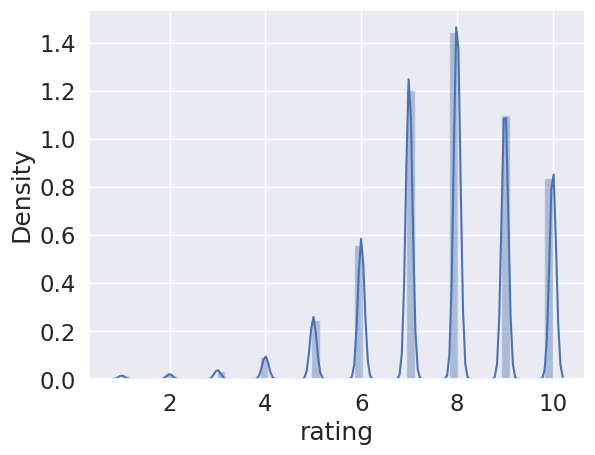

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline

sns.distplot(ratings['rating'])

It appears that users are quite generous in their ratings. The mean rating is 7.80 on a scale of 10. Half the anime have a rating of 8.

Let's also take a look at a subset of 20 anime with the highest rating.

In [6]:
anime.sort_values('rating', ascending=False).head(20)

,anime_id,name,genre,type,episodes,rating,members
10464,33662,Taka no Tsume 8: Yoshida-kun no X-Files,"Comedy, Parody",Movie,1,10.00,13
10400,30120,Spoon-hime no Swing Kitchen,"Adventure, Kids",TV,Unknown,9.60,47
9595,23005,Mogura no Motoro,Slice of Life,Movie,1,9.50,62
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
9078,33607,Kahei no Umi,Historical,Movie,1,9.33,44
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
10786,26313,Yakusoku: Africa Mizu to Midori,"Drama, Kids",OVA,1,9.25,53
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


### Genres
The genres variable will surely be important while building the recommendation engines since it describes the content of the anime (i.e. Shounen, Horror, Sci-Fi). A basic assumption is that anime in the same genre should have similar contents. I'll attempt to see exactly which genres are the most popular.

In [7]:
genre_labels = set()
for s in anime['genre'].str.split(',').values:
    if type(s) == float:
        continue
    genre_labels = genre_labels.union(set(s))

def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census:
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split(','):
        if type(census_keywords) == float and pd.isnull(census_keywords):
            continue
        for s in [s for s in census_keywords if s in census]:
            if pd.notnull(s):
                keyword_count[s] += 1
    keyword_occurrences = []
    for k,v in keyword_count.items():
        keyword_occurrences.append([k,v])
    keyword_occurrences.sort(key = lambda x: x[1], reverse=True)
    return keyword_occurrences, keyword_count

keyword_occurences, dum = count_word(anime, 'genre', genre_labels)
keyword_occurences[:5]

[['Comedy', 3193],
 ['Action', 2845],
 [' Sci-Fi', 1986],
 [' Fantasy', 1815],
 [' Shounen', 1663]]

The top 5 genres are, in that respect order: Comedy, Action, Sci-Fi, Fantasy and Shounen. I'll show this on a wordcloud in order to make it more visually appealing.

In [8]:
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Define the dictionary used to produce the genre wordcloud
genres = dict()
trunc_occurences = keyword_occurences[0:18]
for s in trunc_occurences:
    genres[s[0]] = s[1]

# Create the wordcloud
genre_wordcloud = WordCloud(width=1000,height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(genres)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

ModuleNotFoundError: No module named 'wordcloud'

## Types of Recommendation Engines
### 1. Content Based
The Content-Based Recommender relies on the similarity of the items being recommended. The basic idea is that if you like an item, then you will also like a “similar” item. It generally works well when it's easy to determine the context/properties of each item.

A content based recommender works with data that the user provides, either explicitly anime ratings for our dataset. Based on that data, a user profile is generated, which is then used to make suggestions to the user. As the user provides more inputs or takes actions on the recommendations, the engine becomes more and more accurate
### 2. Collaborative Filtering
The Collaborative Filtering Recommender is entirely based on the past behavior and not on the context. More specifically, it is based on the similarity in preferences, tastes and choices of two users. It analyses how similar the tastes of one user is to another and makes recommendations on the basis of that.

For instance, if user A likes anime 1, 2, 3 and user B likes anime 2,3,4, then they have similar interests and A should like anime 4 and B should like anime 1. This makes it one of the most commonly used algorithm as it is not dependent on any additional information.

In general, collaborative filtering is the workhorse of recommender engines. The algorithm has a very interesting property of being able to do feature learning on its own, which means that it can start to learn for itself what features to use. It can be divided into Memory-Based Collaborative Filtering and Model-Based Collaborative filtering. In this post, I'll only focus on the Memory-Based Collaborative Filtering technique.
![image](https://raw.githubusercontent.com/khanhnamle1994/movielens/cb1fe40c99cdd61c3c714e501e11f699c87b0eed//images/rec-systems.png)

### 3. Matrix Factorization
Model-based Collaborative Filtering is based on matrix factorization (MF)which has received greater exposure, mainly as an unsupervised learning method for latent variable decomposition and dimensionality reduction. Matrix factorization is widely used for recommender systems where it can deal better with scalability and sparsity than Memory-based CF:

- The goal of MF is to learn the latent preferences of users and the latent attributes of items from known ratings (learn features that describe the characteristics of ratings) to then predict the unknown ratings through the dot product of the latent features of users and items.
- When you have a very sparse matrix, with a lot of dimensions, by doing matrix factorization, you can restructure the user-item matrix into low-rank structure, and you can represent the matrix by the multiplication of two low-rank matrices, where the rows contain the latent vector.
- You fit this matrix to approximate your original matrix, as closely as possible, by multiplying the low-rank matrices together, which fills in the entries missing in the original matrix.


A well-known matrix factorization method is Singular value decomposition (SVD). At a high level, SVD is an algorithm that decomposes a matrix A into the best lower rank (i.e. smaller/simpler) approximation of the original matrix A. Mathematically, it decomposes A into a two unitary matrices and a diagonal matrix:
![image](https://miro.medium.com/v2/resize:fit:720/format:webp/1*W4MnB2hyvgqedLmwJLrpqw.png)  
where A is the input data matrix (users’s ratings), U is the left singular vectors (user “features” matrix), Sum is the diagonal matrix of singular values (essentially weights/strengths of each concept), and V^T is the right singular vectors (anime “features” matrix). U and V^T are column orthonormal, and represent different things: U represents how much users “like” each feature and V^T represents how relevant each feature is to each anime.
### 4. Deep Learning Model
The idea of using deep learning is similar to that of Model-Based Matrix Factorization. In matrix factorization, we decompose our original sparse matrix into product of 2 low rank orthogonal matrices. For deep learning implementation, we don’t need them to be orthogonal, we want our model to learn the values of embedding matrix itself. The user latent features and anime latent features are looked up from the embedding matrices for specific anime-user combination. These are the input values for further linear and non-linear layers. We can pass this input to multiple relu, linear or sigmoid layers and learn the corresponding weights by any optimization algorithm (Adam, SGD, etc.).
![image](https://miro.medium.com/v2/resize:fit:720/format:webp/1*OK0qufUIpzzJO1Ofqy5cqw.png)
Here are the main components of my neural network:

- A left embedding layer that creates a Users by Latent Factors matrix.
- A right embedding layer that creates a Anime by Latent Factors matrix.
- When the input to these layers are (i) a user id and (ii) a anime id, they’ll return the latent factor vectors for the user and the anime, respectively.
- A merge layer that takes the dot product of these two latent vectors to return the predicted rating.


This code is based on the approach outlined in [Alkahest’s blog post](http://www.fenris.org/) Collaborative Filtering in Keras.

## Implementation
Due to models 2 and 3 taking huge amounts of calculation and not having appropriate hardware and time I am only implementing model 1 and 4.

## Content Based Recommendation model

In [9]:
anime['genre'] = anime['genre'].str.split(',')
anime['genre'] = anime['genre'].fillna('').astype('str')

I do not have a quantitative metric to judge our machine's performance so this will have to be done qualitatively. In order to do so, I'll use TfidfVectorizer function from scikit-learn, which transforms text to feature vectors that can be used as input to estimator.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(analyzer='word',ngram_range=(1,2),min_df=0.0,stop_words='english')
tfidf_matrix = tf.fit_transform(anime['genre'])
tfidf_matrix.shape

(12294, 654)

I will be using the Cosine Similarity to calculate a numeric quantity that denotes the similarity between two anime. Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's linear_kernel instead of cosine_similarities since it is much faster.

In [11]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:4, :4]

array([[1.        , 0.04304778, 0.        , 0.        ],
       [0.04304778, 1.        , 0.04968007, 0.        ],
       [0.        , 0.04968007, 1.        , 0.11713654],
       [0.        , 0.        , 0.11713654, 1.        ]])

I now have a pairwise cosine similarity matrix for all the anime in the dataset. The next step is to write a function that returns the 20 most similar anime based on the cosine similarity score.

In [12]:
titles = anime['name']
indices = pd.Series(anime.index, index=anime['name'])

def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    anime_indices = [i[0] for i in sim_scores]
    return titles.iloc[anime_indices]

Let's try and get the top recommendations for a few anime and see how good the recommendations are.

In [13]:
genre_recommendations('Gintama')

4                                            Gintama&#039;
8        Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...
9                                 Gintama&#039;: Enchousen
12                                                 Gintama
63             Gintama: Yorinuki Gintama-san on Theater 2D
65                  Gintama Movie: Shinyaku Benizakura-hen
216                       Gintama: Shinyaku Benizakura-hen
306                       Gintama: Jump Festa 2014 Special
10896                                       Gintama (2017)
380      Gintama: Nanigoto mo Saiyo ga Kanjin nano de T...
361                       Gintama: Jump Festa 2015 Special
4301                                         Tono to Issho
4425                        Tono to Issho: Gantai no Yabou
6049                                     Tono to Issho 1.5
171                             Gintama: Shiroyasha Koutan
527                  Hetalia: The Beautiful World Specials
547                           Hetalia: The Beautiful Wor

In [ ]:
genre_recommendations('Naruto')

615                                    Naruto: Shippuuden
841                                                Naruto
1103    Boruto: Naruto the Movie - Naruto ga Hokage ni...
1343                                          Naruto x UT
1472          Naruto: Shippuuden Movie 4 - The Lost Tower
1573    Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...
2458                 Naruto Shippuuden: Sunny Side Battle
2997    Naruto Soyokazeden Movie: Naruto to Mashin to ...
7837                        Battle Spirits: Ryuuko no Ken
7628                              Kyutai Panic Adventure!
1068                          Ranma ½: Akumu! Shunmin Kou
784            Naruto: Shippuuden Movie 6 - Road to Ninja
1796                                       Rekka no Honoo
2416    Naruto: Honoo no Chuunin Shiken! Naruto vs. Ko...
4576                    Street Fighter Zero The Animation
346                                           Dragon Ball
1227                 Dragon Ball Z Movie 14: Kami to Kami
206           

In [14]:
genre_recommendations('Hyouka')

6081                   Tantei Team KZ Jiken Note
1337                                  Cross Road
4069                 Isshuukan Friends. Specials
4906           Mai-Otome Special: Otome no Inori
6621                           Girlfriend (Kari)
6815                                    Turnover
7117           Kanojo ga Kanji wo Suki na Riyuu.
7599                            Tobacco wa Dasai
8129                             Amigo Tomodachi
10650                          Uli Chingu Kkachi
2711                Kindaichi Shounen no Jikenbo
97                                      Nichijou
276                Free!: Eternal Summer Special
317      Hidamari Sketch: Sae Hiro Sotsugyou-hen
418                Tanaka-kun wa Itsumo Kedaruge
452                               Azumanga Daioh
517                        Hidamari Sketch x ☆☆☆
537                  Hidamari Sketch x Honeycomb
558              Jungle wa Itsumo Hare nochi Guu
610               Hidamari Sketch x ☆☆☆ Specials
Name: name, dtype: o

In [15]:
genre_recommendations('Akira')

7067                                 Biohazard 4D-Executer
11950                                        Megami Kyouju
8262                                 Bouken Shounen Shadar
10585                                         Tong Zhi Zhe
6089                                                   Ark
8150                                    Aoki Uru: Overture
10287                                Shuang Yue Zhi Chengi
10941                                             Aoki Uru
5259                     Silent Mobius: The Motion Picture
4274     Digimon Savers: Agumon! Gaomon! Lalamon! Bakur...
5847                                        Submarine 707R
6481                                           Yamato 2520
6968                      Shinkai no Kantai: Submarine 707
7501                                      Seijuuki Cyguard
4646                                             Interlude
2774                                           Ao no 6-gou
3259                       Manie-Manie: Meikyuu Monogata

As you can see, I have quite a decent list of recommendation for Gintama, Naruto, Hyouka and Akira.

Overall, here are the pros of using content-based recommendation:

- No need for data on other users, thus no cold-start or sparsity problems.
- Can recommend to users with unique tastes.
- Can recommend new & unpopular items.
- Can provide explanations for recommended items by listing content-features that caused an item to be recommended (in this case, movie genres)


However, there are some cons of using this approach:

- Finding the appropriate features is hard.
- Does not recommend items outside a user's content profile.
- Unable to exploit quality judgments of other users.

## Deep Learning model
 Here I create a training set by shuffling randomly the values from the original ratings dataset.

In [16]:
shuffled_ratings = ratings.sample(frac=1., random_state=2)

Users = shuffled_ratings['user_emb_id'].values
print('Users:', Users, ', shape =', Users.shape)

Anime = shuffled_ratings['anime_emb_id'].values
print('Anime:', Anime, ', shape =', Anime.shape)

Ratings = shuffled_ratings['rating'].values
print('Ratings:', Ratings, ', shape =', Ratings.shape)

Users: [  299 17087 31269 ... 41826 26491 22705] , shape = (6337241,)
Anime: [10718 14188 18670 ...   873   297  9674] , shape = (6337241,)
Ratings: [8 6 9 ... 9 5 5] , shape = (6337241,)


Build th above described model

In [17]:
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras import Input
from keras.models import Model
from keras.layers import Embedding, Reshape, dot

K_FACTORS = 100 # The number of dimensional embeddings for movies and users

user_target = Input((1,))
anime_context = Input((1,))

embedding_user = Embedding(max_userid, K_FACTORS, input_length=1)
embedding_anime = Embedding(max_animeid, K_FACTORS, input_length=1)

user_embedding = embedding_user(user_target)
user_embedding = Reshape((K_FACTORS,))(user_embedding)
anime_embedding = embedding_anime(anime_context)
anime_embedding = Reshape((K_FACTORS,))(anime_embedding)

# now perform the dot product operation
dot_product = dot([user_embedding, anime_embedding], axes=1)

I then compile the model using Mean Squared Error (MSE) as the loss function and the AdaMax learning algorithm.

In [18]:
model = Model(inputs=[user_target, anime_context], outputs=[dot_product])
model.compile(loss='mean_squared_error', optimizer='adamax')

### Train the model
Now I need to train the model. This step will be the most-time consuming one. In my particular case, for our dataset with nearly 6 million ratings and almost 12,000 anime, I trained the model in roughly 15 minutes per epoch (10 epochs ~ 2.5 hours) on Google Colab T4 GPU. I splitted the training and validataion data with ratio of 90/10.


In [ ]:
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
# Callbacks monitor the validation loss
# Save the model weights each time the validation loss has improved
callbacks = [EarlyStopping('val_loss', patience=2),
             ModelCheckpoint('weights.h5', save_best_only=True)]

# Use 30 epochs, 90% training data, 10% validation data
history = model.fit([Users, Anime], Ratings, epochs=30, validation_split=.1, verbose=2, callbacks=callbacks)

### Loading the pretrained weights

In [19]:
K_FACTORS = 100

# Use the pre-trained model
# user_target = Input((1,))
# anime_context = Input((1,))

# embedding_user = Embedding(max_userid, K_FACTORS, input_length=1)
# embedding_anime = Embedding(max_animeid, K_FACTORS, input_length=1)

# user_embedding = embedding_user(user_target)
# user_embedding = Reshape((K_FACTORS, 1))(user_embedding)
# anime_embedding = embedding_anime(anime_context)
# anime_embedding = Reshape((K_FACTORS, 1))(anime_embedding)

# # now perform the dot product operation
# dot_product = dot([user_embedding, anime_embedding], axes=1)

# trained_model = Model(inputs=model.input, outputs=model.output)
# Load weights
from keras.models import load_model
trained_model = load_model("D:\projrct\Anuime recommendation system\weights.h5")

Function to predict rating given userid and animeid

In [20]:
# Function to predict the ratings given User ID and anime ID
def predict_rating(user_id, anime_id):
    return trained_model.predict([np.array([user_id - 1]), np.array([anime_id - 1])])[0][0]

### Root Mean Squared Error
During the training process above, I saved the model weights each time the validation loss has improved. Thus, I can use that value to calculate the best validation Root Mean Square Error.  
Since we had a very large dataset and limited time we are not optimising it any further but it can be done by adding activation functions to the input and increasing the number of epochs for training.

In [21]:
predictions = trained_model.predict([Users, Anime])

predictions_clipped = np.clip(predictions, 0, 10)
print(predictions)
print(predictions_clipped)
predictions_rounded = np.round(predictions_clipped)
predictions_rounded = predictions_rounded.astype('int64')
print(predictions_rounded)

from sklearn.metrics import mean_squared_error

print(Ratings)
print(predictions)
mse = mean_squared_error(Ratings, predictions)
print("MSE is ", mse)
print("RMSE is ", np.sqrt(mse))

198039/198039 [==============================] - 455s 2ms/step
[[8.018846 ]
 [7.2138925]
 [6.9302897]
 ...
 [7.647041 ]
 [5.4274387]
 [5.7161674]]
[[8.018846 ]
 [7.2138925]
 [6.9302897]
 ...
 [7.647041 ]
 [5.4274387]
 [5.7161674]]
[[8]
 [7]
 [7]
 ...
 [8]
 [5]
 [6]]
[8 6 9 ... 9 5 5]
[[8.018846 ]
 [7.2138925]
 [6.9302897]
 ...
 [7.647041 ]
 [5.4274387]
 [5.7161674]]
MSE is  1.879368407416379
RMSE is  1.3709005826158143


RMSE of 1.37 is not bad at all as a little randomness in recommendations is a good thing.


### Testing the recommendations
We take a test user and compare actual ratings with recommended ratings

In [22]:
TEST_USER = 12
user_ratings = ratings[ratings['user_id'] == TEST_USER][['user_id', 'anime_id', 'rating']]
user_ratings['prediction'] = user_ratings.apply(lambda x: predict_rating(TEST_USER, x['anime_id']), axis=1)
user_ratings.sort_values(by='rating',
                         ascending=False).merge(anime,
                                                on='anime_id',
                                                how='inner',
                                                suffixes=['_u', '_m']).head(20)

1/1 [==============================] - 0s 27ms/step


,user_id,anime_id,rating_u,prediction,name,genre,type,episodes,rating_m,members
0,12,2904,10,9.629661,Code Geass: Hangyaku no Lelouch R2,"['Action', ' Drama', ' Mecha', ' Military', ' ...",TV,25,8.98,572888
1,12,1535,10,9.599850,Death Note,"['Mystery', ' Police', ' Psychological', ' Sup...",TV,37,8.71,1013917
2,12,9253,10,9.836137,Steins;Gate,"['Sci-Fi', ' Thriller']",TV,24,9.17,673572
3,12,1575,10,9.535017,Code Geass: Hangyaku no Lelouch,"['Action', ' Mecha', ' Military', ' School', '...",TV,25,8.83,715151
4,12,16498,10,9.374858,Shingeki no Kyojin,"['Action', ' Drama', ' Fantasy', ' Shounen', '...",TV,25,8.54,896229
5,12,853,9,9.122396,Ouran Koukou Host Club,"['Comedy', ' Harem', ' Romance', ' School', ' ...",TV,26,8.39,422271
6,12,877,9,9.358855,Nana,"['Comedy', ' Drama', ' Music', ' Romance', ' S...",TV,47,8.55,197256
7,12,11757,9,8.810209,Sword Art Online,"['Action', ' Adventure', ' Fantasy', ' Game', ...",TV,25,7.83,893100
8,12,302,9,9.093646,Mirai Shounen Conan,"['Adventure', ' Drama', ' Sci-Fi']",TV,26,8.16,15557
9,12,8888,9,8.409307,Code Geass: Boukoku no Akito 1 - Yokuryuu wa M...,"['Action', ' Mecha', ' Military', ' Sci-Fi']",Movie,1,7.66,91105


### Recommending Anime
We take the anime the user has not watched and predict the rating a particular user gives, sort the values and recommend the top 20.

In [23]:
recommendations = anime[anime['anime_id'].isin(user_ratings['anime_id']) == False][['anime_id', 'rating']]
recommendations['prediction'] = recommendations.sort_values(by='rating', ascending=False).head(100).apply(lambda x: predict_rating(TEST_USER, x['anime_id']), axis=1)
recommendations.sort_values(by='prediction',
                          ascending=False).merge(anime,
                                                 on='anime_id',
                                                 how='inner',
                                                 suffixes=['_u', '_m']).head(20)

1/1 [==============================] - 0s 13ms/step


,anime_id,rating_u,prediction,name,genre,type,episodes,rating_m,members
0,820,9.11,10.849271,Ginga Eiyuu Densetsu,"['Drama', ' Military', ' Sci-Fi', ' Space']",OVA,110,9.11,80679
1,28977,9.25,10.357701,Gintama°,"['Action', ' Comedy', ' Historical', ' Parody'...",TV,51,9.25,114262
2,15417,9.11,10.054437,Gintama&#039;: Enchousen,"['Action', ' Comedy', ' Historical', ' Parody'...",TV,13,9.11,81109
3,32935,9.15,10.014520,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"['Comedy', ' Drama', ' School', ' Shounen', ' ...",TV,10,9.15,93351
4,32281,9.37,10.010857,Kimi no Na wa.,"['Drama', ' Romance', ' School', ' Supernatural']",Movie,1,9.37,200630
5,22135,8.67,9.989648,Ping Pong The Animation,"['Psychological', ' Seinen', ' Sports']",TV,11,8.67,97187
6,9969,9.16,9.953746,Gintama&#039;,"['Action', ' Comedy', ' Historical', ' Parody'...",TV,51,9.16,151266
7,7785,8.65,9.932184,Yojouhan Shinwa Taikei,"['Mystery', ' Psychological', ' Romance']",TV,11,8.65,122531
8,11061,9.13,9.931136,Hunter x Hunter (2011),"['Action', ' Adventure', ' Shounen', ' Super P...",TV,148,9.13,425855
9,15335,9.10,9.929960,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"['Action', ' Comedy', ' Historical', ' Parody'...",Movie,1,9.10,72534


As we can see the recommendations are very good based on what the user already rated good.

## Conclusion
- Content based model is not very user specific but good enough for new users and and users who specifically want generic and dumb recommendations.  
- Models 2, 3, and 4 have a problem called cold start in which we dont know the tastes of a new user, and similarity of a new anime. This problem can be solved by extending recommedation engines with a content based model which recommends based on anime metadata like genres, type of anime, length, release date, etc.